# Ray Implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import ray
import joblib
from ray.util.joblib import register_ray
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC

SEED = 42

In [2]:
register_ray()

In [3]:
ray.init(address="ray://172.31.88.97:10001")

Python version:,3.10.12
Ray version:,2.10.0
Dashboard:,http://127.0.0.1:8265


## Read data

In [4]:
# Split data into X and y
X_reg_train = pd.read_csv('../data/X_reg_train.csv')
X_reg_test = pd.read_csv('../data/X_reg_test.csv')

X_class_train = pd.read_csv('../data/X_class_train.csv')
X_class_test = pd.read_csv('../data/X_class_test.csv')

y_reg_train = pd.read_csv('../data/y_reg_train.csv')
y_reg_test = pd.read_csv('../data/y_reg_test.csv')

y_class_train = pd.read_csv('../data/y_class_train.csv')
y_class_test = pd.read_csv('../data/y_class_test.csv')

In [8]:
X_reg_test.shape

(4000000, 5)

## Dask Experiment Function

In [14]:
def ray_time_algorithm(subset_prop, algorithm_name, SEED=SEED):
    '''
    algorithm_name one of 'KNN', 'RF', 'KMEANS'
    '''
    if (algorithm_name == "KNN" or algorithm_name == "RF"):
        X_reg_train_subset = X_reg_train.head(int(len(X_reg_train) * subset_prop))
        X_reg_test_subset = X_reg_test.head(int(len(X_reg_test) * subset_prop))
        y_reg_train_subset = y_reg_train.head(int(len(y_reg_train) * subset_prop))
        y_reg_test_subset = y_reg_test.head(int(len(y_reg_test) * subset_prop))

        print(f'X_reg_train_subset shape {X_reg_train_subset.shape}')
        print(f'X_reg_test_subset shape {X_reg_test_subset.shape}')
        print(f'y_reg_train_subset shape {y_reg_train_subset.shape}')
        print(f'y_reg_test_subset shape {y_reg_test_subset.shape}')
       
    elif (algorithm_name == "KMEANS"):
        X_class_train_subset = X_class_train.head(int(len(X_class_train) * subset_prop))
        X_class_test_subset = X_class_test.head(int(len(X_class_test) * subset_prop))
        y_class_train_subset = y_class_train.head(int(len(y_class_train) * subset_prop))
        y_class_test_subset = y_class_test.head(int(len(y_class_test) * subset_prop))
       
    start_time = time.time()
       
    if algorithm_name == "KNN":
        with joblib.parallel_backend('ray'):
            knn_model = KNeighborsRegressor(n_neighbors=5)
            knn_model.fit(X_reg_train_subset, y_reg_train_subset)
            metric = knn_model.score(X_reg_test_subset, y_reg_test_subset) # metric is KNN accuracy
                       
    elif algorithm_name == "KMEANS":
        with joblib.parallel_backend('ray'):
            kmeans_model = KMeans(n_clusters=2, random_state=SEED, n_init="auto")
            kmeans_model.fit(X_class_train_subset)
            metric = None # No performance metric for KMEANS (unsupervised)
    
    # #OLD CODE
    # elif algorithm_name == "RF":
    #     with joblib.parallel_backend('ray'):
    #         rf_model = RandomForestRegressor(max_depth=2, random_state=SEED)
    #         rf_model.fit(X_reg_train_subset, y_reg_train_subset)
    #         y_pred = rf_model.predict(X_reg_test_subset)
    #         metric = mean_squared_error(y_reg_test_subset, y_pred) # metric is random forest MSE
    
    elif algorithm_name == "RF":
        with joblib.parallel_backend('ray'):
            X_reg_train_subset_ray = ray.put(X_reg_train_subset)
            y_reg_train_subset_ray = ray.put(y_reg_train_subset)
            X_reg_test_subset_ray = ray.put(X_reg_test_subset)
            y_reg_test_subset_ray = ray.put(y_reg_test_subset)
            rf_model = RandomForestRegressor(max_depth=2, random_state=SEED)
            @ray.remote
            def process_data(data_list_train, data_list_test): #add model here
                processed_data = rf_model.fit(data_list_train[0], data_list_train[1])
                y_pred = data_list_test.apply(lambda x: rf_model.predict(x[0]))
                rf_metric = data_list_test.apply(lambda x: mean_squared_error(x[1], y_pred))
                return rf_metric
            metric = process_data.remote([X_reg_train_subset_ray,y_reg_train_subset_ray],[X_reg_test_subset_ray,y_reg_test_subset_ray]).get()
           
    end_time = time.time()
    time_delta = end_time - start_time
    return time_delta, metric

## Set proportions to loop over

In [7]:
props = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

## KNN Test

In [12]:
knn_times = []
knn_metrics = []

for prop in props:
    print(prop)
    runtime, metric = ray_time_algorithm(prop, algorithm_name="KNN")
    knn_times.append(runtime)
    knn_metrics.append(metric)
   
print(knn_times)
print(knn_metrics)

0.1
X_reg_train_subset shape (1600000, 5)
X_reg_test_subset shape (400000, 5)
y_reg_train_subset shape (1600000, 2)
y_reg_test_subset shape (400000, 2)


2024-04-16 22:32:24,710	WARNING pool.py:589 -- The 'context' argument is not supported using ray. Please refer to the documentation for how to control ray initialization.
/home/ubuntu/.local/lib/python3.10/site-packages/ray/util/client/worker.py:619: UserWarning: More than 10MB of messages have been created to schedule tasks on the server. This can be slow on Ray Client due to communication overhead over the network. If you're running many fine-grained tasks, consider running them inside a single remote function. See the section on "Too fine-grained tasks" in the Ray Design Patterns document for more details: https://docs.google.com/document/d/167rnnDFIVRhHhK4mznEIemOtj63IOhtIPvSYaPgI4Fg/edit#heading=h.f7ins22n6nyl. If your functions frequently use large objects, consider storing the objects remotely with ray.put. An example of this is shown in the "Closure capture of large / unserializable object" section of the Ray Design Patterns document, available here: https://docs.google.com/doc

0.2
X_reg_train_subset shape (3200000, 5)
X_reg_test_subset shape (800000, 5)
y_reg_train_subset shape (3200000, 2)
y_reg_test_subset shape (800000, 2)
0.3
X_reg_train_subset shape (4800000, 5)
X_reg_test_subset shape (1200000, 5)
y_reg_train_subset shape (4800000, 2)
y_reg_test_subset shape (1200000, 2)
0.4
X_reg_train_subset shape (6400000, 5)
X_reg_test_subset shape (1600000, 5)
y_reg_train_subset shape (6400000, 2)
y_reg_test_subset shape (1600000, 2)


OutOfMemoryError: Task was killed due to the node running low on memory.
Memory on the node (IP: 172.31.88.97, ID: f5a7317755e156c9223c5e9c867ab0aeeb6c7c5f66ddea42817ec957) where the task (actor ID: 17ee5dcb56f0f62042fdad4702000000, name=PoolActor.__init__, pid=2694, memory used=0.05GB) was running was 7.26GB / 7.63GB (0.952273), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 2e8e9510995b6b3074270bcd5842e06e60256272c16b40bca1e8d1a8) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 172.31.88.97`. To see the logs of the worker, use `ray logs worker-2e8e9510995b6b3074270bcd5842e06e60256272c16b40bca1e8d1a8*out -ip 172.31.88.97. Top 10 memory users:
PID	MEM(GB)	COMMAND
1309	1.79	/usr/bin/python3 -m ipykernel_launcher -f /home/ubuntu/.local/share/jupyter/runtime/kernel-efd270b9-...
1510	0.53	/usr/bin/python3 -m ray.util.client.server --address=172.31.88.97:6379 --host=0.0.0.0 --port=23000 -...
964	0.16	/usr/bin/python3 -m ray.util.client.server --address=172.31.88.97:6379 --host=0.0.0.0 --port=10001 -...
965	0.12	/usr/bin/python3 /home/ubuntu/.local/lib/python3.10/site-packages/ray/dashboard/dashboard.py --host=...
1021	0.10	/home/ubuntu/.local/lib/python3.10/site-packages/ray/core/src/ray/raylet/raylet --raylet_socket_name...
862	0.08	/usr/bin/python3 /home/ubuntu/.local/bin/jupyter-notebook
1943	0.08	ray::_StatsActor
1060	0.06	/usr/bin/python3 -u /home/ubuntu/.local/lib/python3.10/site-packages/ray/dashboard/agent.py --node-i...
2694	0.05	ray::PoolActor
1285	0.04	/usr/bin/python3 -m ipykernel_launcher -f /home/ubuntu/.local/share/jupyter/runtime/kernel-87015100-...
Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. Set max_restarts and max_task_retries to enable retry when the task crashes due to OOM. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.

### Ray ran out of memory on head node in KNN for 0.4 of full data

In [17]:
knn_frame = pd.DataFrame(list(zip(knn_times, knn_metrics)), columns=['Time', 'Metric'], index=[0.1, 0.2, 0.3])
knn_frame.head()

,Time,Metric
0.1,25.820062,0.570870
0.2,45.606875,0.633325
0.3,73.046246,0.677940


Text(0, 0.5, 'Time (s)')

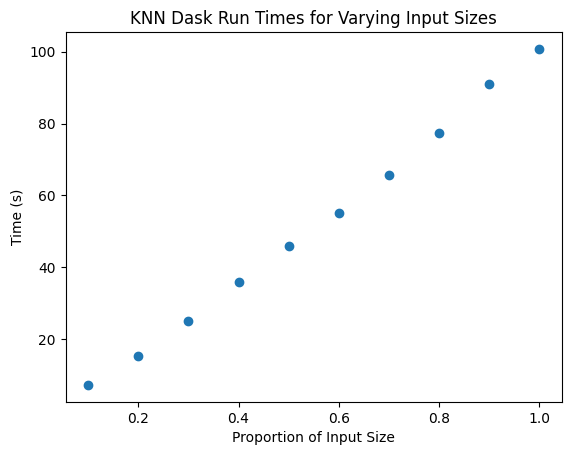

In [35]:
plt.scatter(x=knn_frame.index, y=knn_frame['Time'])
plt.title('KNN Ray Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [19]:
knn_frame.to_csv('ray_knn_results.csv', index=True)

## KMeans Test

In [14]:
kmeans_times = []
kmeans_metrics = []

for prop in props:
    print(prop)
    runtime, metric = ray_time_algorithm(prop, algorithm_name="KMEANS")
    kmeans_times.append(runtime)
    kmeans_metrics.append(metric)
   
print(kmeans_times)
print(kmeans_metrics)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
[1.2320852279663086, 2.449437141418457, 3.2872731685638428, 4.160694599151611, 4.0778796672821045, 7.292481899261475, 6.677386283874512, 8.229593276977539, 9.156158685684204, 9.519452571868896]
[None, None, None, None, None, None, None, None, None, None]


In [15]:
kmeans_frame = pd.DataFrame(list(zip(kmeans_times, kmeans_metrics)), columns=['Time', 'Metric'], index=props)
kmeans_frame.head()

,Time,Metric
0.1,1.232085,None
0.2,2.449437,None
0.3,3.287273,None
0.4,4.160695,None
0.5,4.077880,None


Text(0, 0.5, 'Time (s)')

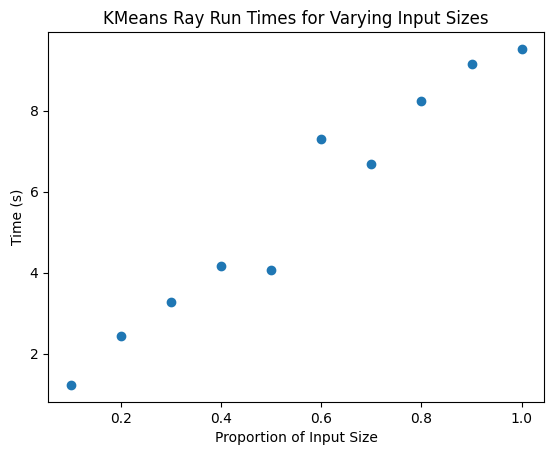

In [18]:
plt.scatter(x=kmeans_frame.index, y=kmeans_frame['Time'])
plt.title('KMeans Ray Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [20]:
kmeans_frame.to_csv('ray_kmeans_results.csv', index=True)

## Random Forest Test

In [8]:
rf_times = []
rf_metrics = []

for prop in props:
    print(prop)
    runtime, metric = ray_time_algorithm(prop, algorithm_name="RF")
    rf_times.append(runtime)
    rf_metrics.append(metric)
   
print(rf_times)
print(rf_metrics)

0.1
X_reg_train_subset shape (1600000, 5)
X_reg_test_subset shape (400000, 5)
y_reg_train_subset shape (1600000, 2)
y_reg_test_subset shape (400000, 2)
0.2
X_reg_train_subset shape (3200000, 5)
X_reg_test_subset shape (800000, 5)
y_reg_train_subset shape (3200000, 2)
y_reg_test_subset shape (800000, 2)
0.3
X_reg_train_subset shape (4800000, 5)
X_reg_test_subset shape (1200000, 5)
y_reg_train_subset shape (4800000, 2)
y_reg_test_subset shape (1200000, 2)
0.4
X_reg_train_subset shape (6400000, 5)
X_reg_test_subset shape (1600000, 5)
y_reg_train_subset shape (6400000, 2)
y_reg_test_subset shape (1600000, 2)
0.5
X_reg_train_subset shape (8000000, 5)
X_reg_test_subset shape (2000000, 5)
y_reg_train_subset shape (8000000, 2)
y_reg_test_subset shape (2000000, 2)


KeyboardInterrupt: 

### Ray fails, runs out of memory on 0.2 of full data.

In [10]:
rf_frame = pd.DataFrame(list(zip(rf_times, rf_metrics)), columns=['Time', 'Metric'], index=[0.1, 0.2, 0.3, 0.4])
rf_frame.head()

,Time,Metric
0.1,4.327522,ClientObjectRef(67a2e8cfa5a06db3ffffffffffffff...
0.2,4.697106,ClientObjectRef(e082c90ab8422b00ffffffffffffff...
0.3,6.856346,ClientObjectRef(e5cbd90b7f1fb776ffffffffffffff...
0.4,8.941291,ClientObjectRef(39088be3736e590affffffffffffff...


In [15]:
ray.get(rf_frame.iloc[0].Metric)

RayTaskError(AttributeError): [36mray::process_data()[39m (pid=1246, ip=172.31.88.97)
  File "/tmp/ipykernel_892/792335329.py", line 53, in process_data
AttributeError: 'list' object has no attribute 'apply'

Text(0, 0.5, 'Time (s)')

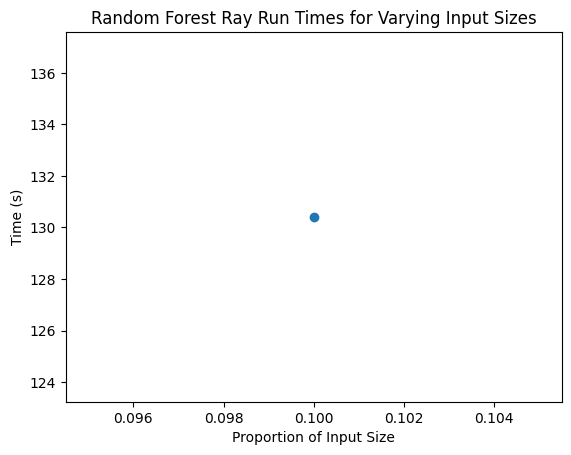

In [25]:
plt.scatter(x=rf_frame.index, y=rf_frame['Time'])
plt.title('Random Forest Ray Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [26]:
rf_frame.to_csv('ray_rf_results.csv', index=True)